In [31]:
import patato as pat
import matplotlib.pyplot as plt
import numpy as np

In [32]:
padata = pat.PAData.from_hdf5("../Data/23_5.hdf5")[:, :-1]

In [33]:
image_data = np.squeeze(
    padata.get_scan_reconstructions()["Model Based", "0"].raw_data
)

In [34]:
# image_data = np.load('simulations/simulated_data.npy')

In [35]:
image_data.shape

(12, 400, 400)

In [36]:
wavelengths = padata.get_wavelengths()
melanin = 519 * (wavelengths / 500) ** (-3.5) * 0.4

In [37]:
wavelengths

array([ 700.,  730.,  760.,  800.,  850.,  910.,  930.,  950.,  980.,
       1030., 1080., 1100.])

In [38]:
n, x, y = image_data.shape
assert n == len(wavelengths)

Text(0.5, 1.0, 'Melanin Spectrum')

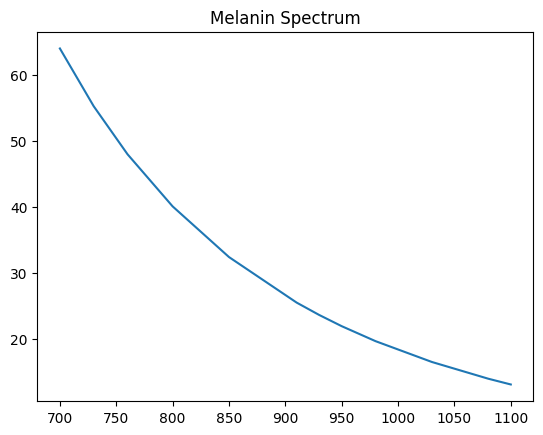

In [39]:
plt.plot(wavelengths, melanin)
plt.title("Melanin Spectrum")

In [40]:
image_flat = image_data.reshape(n, -1)
print(image_flat.shape)
print(melanin.shape)

(12, 160000)
(12,)


In [41]:
# melanin_unit = melanin / np.linalg.norm(melanin)**2
# coeffs = np.dot(melanin, image_flat)  # shape: (pixels,)
# projection_flat = np.outer(melanin_unit, coeffs)  # shape: (13, 160000)


In [49]:
# Normalize each pixel spectrum
pixel_norms = np.linalg.norm(image_flat, axis=0, keepdims=True)
image_unit = np.divide(image_flat, pixel_norms, where=pixel_norms != 0)

# Normalize melanin spectrum
melanin_norm = melanin / np.linalg.norm(melanin)

# Compute cosine similarity
cos_sim = np.clip(np.dot(melanin_norm, image_unit).reshape(x, y), 0, 1)

In [50]:
# coeffs = np.dot(melanin, image_flat) / np.linalg.norm(melanin)**2
projection_flat = np.outer(melanin, cos_sim)

In [51]:
projection = projection_flat.reshape(n, x, y)
# coeffs_img = coeffs.reshape(x, y)

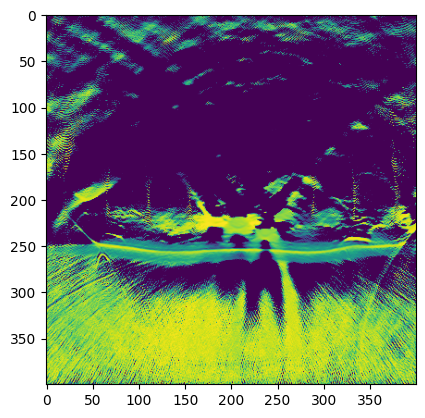

In [53]:
plt.imshow(cos_sim)

In [54]:
# Calculate subtraction (in theory, PAI without mUS clutter)
pai = image_data - projection

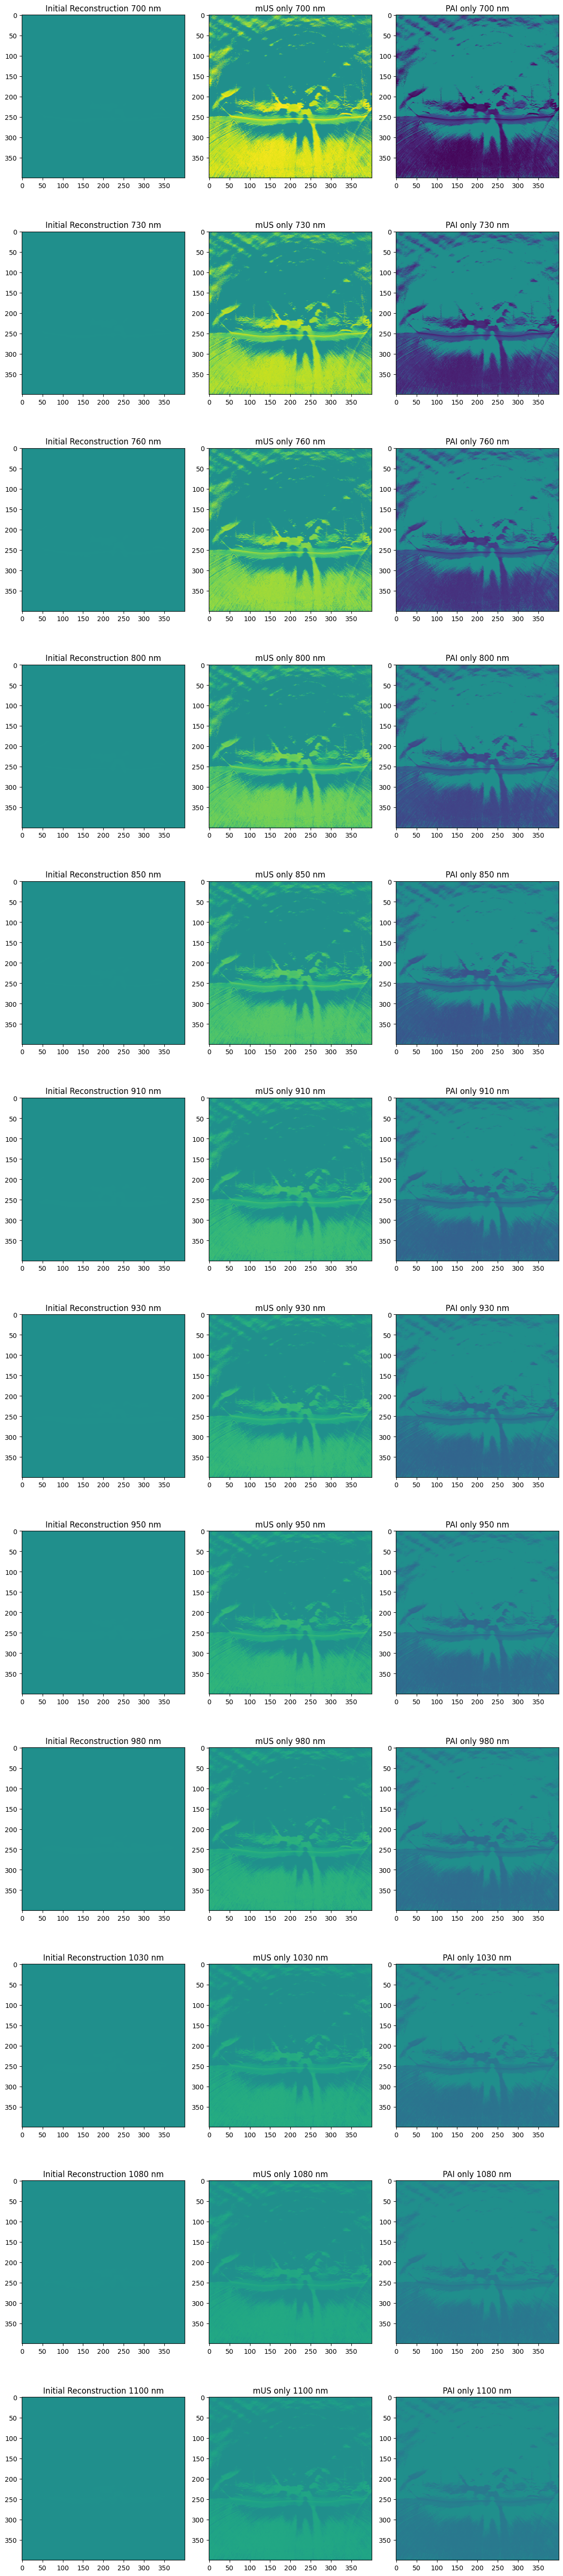

In [55]:
fig, ax = plt.subplots(n, 3, figsize=(12, 55))

# Compute common colour scale for whole figure
vmin = min(image_data[:].min(), projection[:].min(), pai[:].min())
vmax = max(image_data[:].max(), projection[:].max(), pai[:].max())

for i in range(n):
    # Compute common color scale for this row
    # vmin = min(image_data[i].min(), projection[i].min(), pai[i].min())
    # vmax = max(image_data[i].max(), projection[i].max(), pai[i].max())

    # Plot PAI full
    im0 = ax[i, 0].imshow(image_data[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax[i, 0].set_title(f"Initial Reconstruction {int(wavelengths[i])} nm")

    # Plot mUS only
    im1 = ax[i, 1].imshow(projection[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax[i, 1].set_title(f"mUS only {int(wavelengths[i])} nm")

    # Plot PAI only
    im2 = ax[i, 2].imshow(pai[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax[i, 2].set_title(f"PAI only {int(wavelengths[i])} nm")

plt.tight_layout()
plt.show()


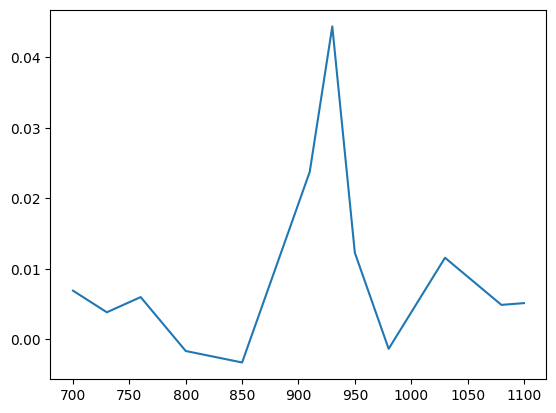

In [78]:

plt.plot(wavelengths, image_data[:, 260, 200])

### Make a simulated image with artefacts and see how it does